![](img/574_banner.png)

# Lab 3: Forecasting Competition

**Tomas Beuzen, 2021**

![](img/superhard.png)

## Table of Contents
<hr>

<div class="toc"><ul class="toc-item"><li><span><a href="#Instructions" data-toc-modified-id="Instructions-2">Instructions</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li><li><span><a href="#Forecasting-Competition" data-toc-modified-id="Forecasting-Competition-4">Forecasting Competition</a></span></li><li><span><a href="#Your-Code-Goes-Here" data-toc-modified-id="Your-Code-Goes-Here-5">Your Code Goes Here</a></span></li><li><span><a href="#Submit-to-Canvas-and-GitHub" data-toc-modified-id="Submit-to-Canvas-and-GitHub-6">Submit to Canvas and GitHub</a></span></li></ul></div>

## Instructions
<hr>

rubric={mechanics:3}

# [GITHUB LINK](https://github.ubc.ca/MDS-2020-21/DSCI_574_lab3_dandrew9)

**Link to your GitHub repository:**

You will receive marks for correctly submitting this assignment. To submit this assignment you should:

1. Push your assignment to your GitHub repository!
2. Provide a link to your repository in the space provided above.
2. Upload a HTML render of your assignment to Canvas. The last cell of this notebook will help you do that.
3. Be sure to follow the [General Lab Instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/). You can view a description of the different rubrics used for grading in MDS [here](https://github.com/UBC-MDS/public/tree/master/rubric).

Here's a break down of the required and optional exercises in this lab:

|         | Number of Exercises | Points |
|:-------:|:-------------------:|:------:|
| Mechanics| - | 3 |
| Required| 1 | 20 |
| Optional| 0  | 0 |

## Imports
<hr>

In [22]:
# Standard things
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Statsmodels
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL

# Sklearn modelling
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline

# Maybe use Prophet?
# from fbprophet import Prophet

# Custom helpers
import utils.sklearn_utils as sku 
import utils.tsfresh_utils as tfu

# Tsfresh extraction sets
from tsfresh.feature_extraction import (
    EfficientFCParameters,
    MinimalFCParameters,
    ComprehensiveFCParameters,
)

# Other model types
from lightgbm import LGBMRegressor

# Utils
from canvasutils.submit import submit, convert_notebook
from itertools import product
import warnings

# For reloading helper files on change:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2, "figure.figsize":(15,4)})

## Forecasting Competition
<hr>

rubric={viz:5,efficiency:5,accuracy:10}

It's Week 3 - so we have a lighter lab this week. In fact, you can spend as little or as much time as you want on this lab! We will be having a little forecasting competition!

### Background and Tasks

A few years ago I participated in a conference where beach shoreline modellers from around the world competed to make accurate predictions of a particular beach shoreline time series (similar to the one we've been seeing in lectures throughout this course). Participants were given a 15 year time series (1999 - 2013, inclusive) of *daily* data of the shoreline location in meters from a datum (just think of it as the width of the beach) of Tairua Beach in New Zealand, and were tasked with predicting the *monthly* shoreline location for the next 3 years (2014 - 2016, inclusive).

Your tasks in this lab are simple:
1. Predict the monthly beach shoreline location over the test period (Jan 2014 - Dec 2016, inclusive: that's 36 months) and export your predictions into the csv `data/beach-test.csv` I've included with your lab (read more details about that in the next section); and,
2. Make a plot of the training data and your predictions using any plotting library you wish (I want you to get into the habit of always plotting your predictions, the insight you can get from a visual examination of your predictions is priceless).

If you're wondering. I placed third in the competition with a pretty simple random forest model and won a hat. I know much more now than I did then though, and if I had my time again, I'd do things differently... My advice: plot the time series, decompose it a bit, find out what it's made of. Is the seasonal signal strong? Are there multiple seasonal cycles? Choose a model or include features that can account for that. Is there a trend? Better try a model that can capture that. Try fitting models that capture the elements you see in the series. Ensembling different models that capture different aspects of the series might also be a great idea.

### Data and Submission

I have provided you with several relevant data files in the `data/` folder:

- `beach-train.csv`: 15 years of *daily* shoreline data.
- `beach-test.csv`: template you should use to make *monthly* shoreline predictions for Jan 2014 - Dec 2016.
- `waves-train.csv` (optional): file of monthly wave height and wave period you may wish to use as explanatory variables.
- `waves-test.csv` (optional): monthly wave height and wave period over the test period.

You should make your predictions using the `beach-test.csv` template provided to you in your repo. **Be sure to push this .csv file to GitHub so I can evaluate it**. You should also submit a HTML-render of your assignment to Canvas as-per-usual (following the usual instructions at the end of the lab assignment) so we can look at your code and plot (you do not need to submit your .csv predictions to Canvas).

### Evaluation

Following in the footsteps of the [M4 time series competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), submissions will be evaluated based on the average of two metrics:
1. Symmetric mean absolute percentage error (sMAPE)

$$\text{sMAPE}=\frac{2}{h}\sum_{t=n+1}^{n+h}\frac{|y_t-\hat{y_t}|}{|y_t|+|\hat{y_t}|}*100(\%)$$

2. Mean absolute scaled error (MASE)

$$\text{MASE}=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h}|y_t-\hat{y_t}|}{\frac{1}{n-1}\sum_{t=2}^{n}|y_t-y_{t-1}|}$$

Where $y_t$ is the value of the series at time $t$, $\hat{y_t}$ is the forecast at time $t$, $h$ is the forecast horizon, $n$ is the number of training samples.

### Prizes

- **1st**: A hard-copy of [The Signal and the Noise: Why So Many Predictions Fail — But Some Don't](https://www.goodreads.com/book/show/13588394-the-signal-and-the-noise) shipped to your door, and 100% on Lab 1, Lab 2, and Lab 3.
- **2nd**: 100% on Lab 1, Lab 2, and Lab 3.
- **3rd**: 100% on Lab 3, and Lab 1 or Lab 2.
- **Top 10**: 100% on Lab 3.

![](img/winner.png)

## Your Code Goes Here
<hr>

In [24]:
# Grab data and lowercase everything!
# Ensure frequency is set on indexes for use with other libraries to forecast

# Shoreline data -----------------------------------------------------------------
df_train = pd.read_csv("data/beach-train.csv", index_col="Time", parse_dates=True) \
    .rename(columns={"Shoreline":"shoreline"})   
df_train.index.rename("time", inplace=True)

df_test = pd.read_csv("data/beach-test.csv", index_col="Time", parse_dates=True) \
    .rename(columns={"Shoreline":"shoreline"}) 
df_test.index.rename("time", inplace=True)
df_test.index = pd.to_datetime(df_test.index, format="%b-%y")
df_test = df_test.resample("MS").first()

# Exogenous data ----------------------------------------------------------------------
# Read in mostly raw for now, we'll feature engineer in later chunks
df_waves_train = pd.read_csv("data/waves-train.csv", index_col="time", parse_dates=True)

df_soi = (
    pd.read_csv("data/soi.csv", index_col="date", parse_dates=["date"], names=["date","soi"], header=0) 
    .resample("MS")
    .mean()
)

# Sea level anomaly and geostrophic velocity data derived around Tairua Beach.
df_sea_data = pd.read_csv("data/df_sea_data.csv", index_col="time", parse_dates=["time"]).resample("MS").mean()  


### EDA

In [25]:
df_waves_train.head()

,wave_height,wave_power
time,,
1999-01-01,1.052976,5910.511774
1999-02-01,1.163165,7214.323661
1999-03-01,1.034512,5941.512500
1999-04-01,1.110688,7442.741000
1999-05-01,0.763710,3350.945081


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001626BE0CD08>,
      dtype=object)

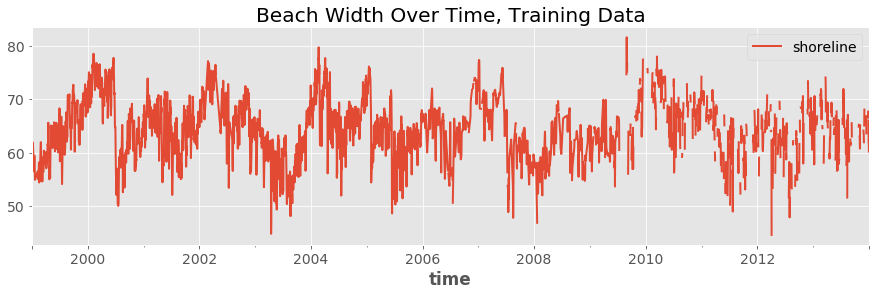

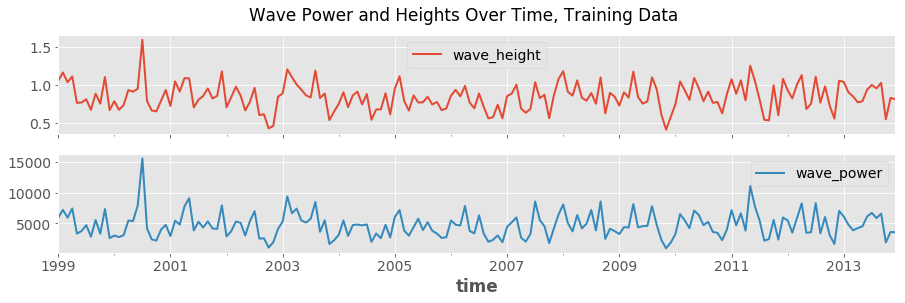

In [26]:
df_train.plot(title="Beach Width Over Time, Training Data");
df_waves_train.plot(title="Wave Power and Heights Over Time, Training Data", subplots=True);


In [27]:
df_soi.head()

,soi
date,
1951-01-01,1.5
1951-02-01,0.9
1951-03-01,-0.1
1951-04-01,-0.3
1951-05-01,-0.7


In [28]:
df_sea_data.head()

,adt,ugos,vgos
time,,,
1999-01-01,0.702449,0.039391,0.007581
1999-02-01,0.750522,0.024643,-0.008642
1999-03-01,0.747959,0.063536,-0.003094
1999-04-01,0.708139,0.079983,-0.014354
1999-05-01,0.719036,0.079695,-0.016381


In [29]:
df_train_merged = (
    df_train.resample("MS")
    .mean()
    .merge(df_waves_train, left_index=True,how="left", right_index=True)
    .merge(df_soi, left_index=True, right_index=True)
    .merge(df_sea_data, left_index=True, right_index=True)
)

# Set for later:
exog_vars = ["wave_power", "wave_height", "soi", "adt", "vgos", "ugos"]

print(df_train_merged.shape)
df_train_merged.head()

(180, 7)


,shoreline,wave_height,wave_power,soi,adt,ugos,vgos
1999-01-01,57.509911,1.052976,5910.511774,1.8,0.702449,0.039391,0.007581
1999-02-01,56.589458,1.163165,7214.323661,1.0,0.750522,0.024643,-0.008642
1999-03-01,57.779581,1.034512,5941.512500,1.3,0.747959,0.063536,-0.003094
1999-04-01,59.224900,1.110688,7442.741000,1.4,0.708139,0.079983,-0.014354
1999-05-01,62.658231,0.763710,3350.945081,0.2,0.719036,0.079695,-0.016381


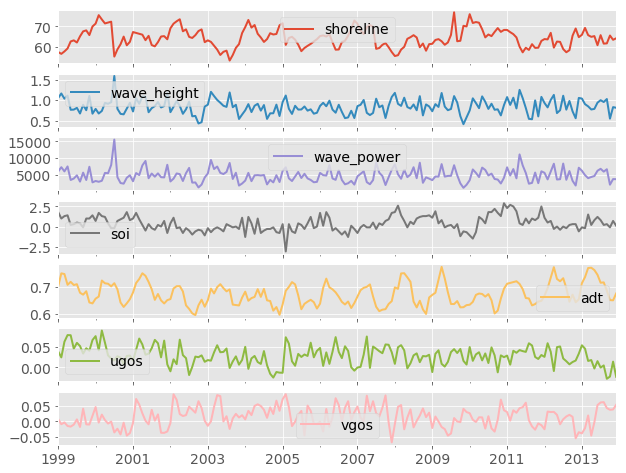

In [30]:
df_train_merged.plot(figsize=(10,8),subplots=True);

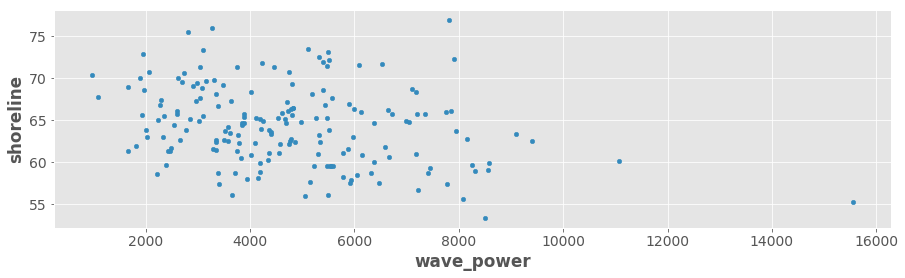

In [31]:
df_train_merged.plot(kind="scatter", x="wave_power", y="shoreline")

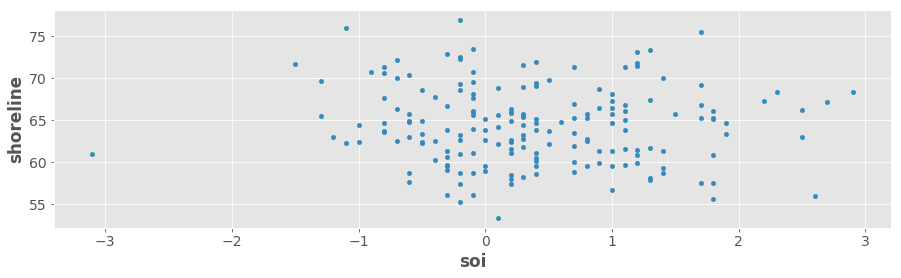

In [32]:
df_train_merged.plot(kind="scatter", x="soi", y="shoreline")

If you squint - it appears spikes in wave_power and wave_height appear to decrease beach_width...we'll see if it can be helpful. It also appears the trend is not consistent and the seasonal periods are hard to identify. Any trend in `soi` is harder to see - we'll play more with different smoothing in feature engineering.

### Modelling

First we'll look at decomposing the series and using SARIMAX/STL for forecasting and see if exogenous variables help.

We'll work with a portion of our dataset as a CV validataion dataset for quick prototyping.


In [33]:
# Helper metrics

def smape(y_actual, y_pred, h=1):
    """Calculate symmetric mean absolute percentage error 

    Parameters
    ----------
    y_actual : array-like
        Ground truth values
    y_pred : array-like
        Predicted values
    h : int, optional
        The forecast horizon, by default 1

    Returns
    -------
    float : 
        The sMAPE of the `y_pred` against `y_actual`
    """
    return np.mean(2.0 * np.abs(y_actual - y_pred) / ((np.abs(y_actual) + np.abs(y_pred))*h))
    
def mase(y_actual, y_pred, h=1):
    """Calculates the mean averaged scaled error for a time series by comparing
    to the naive forecast (shift h prior value forward as the forecast)

    Parameters
    ----------
    y_actual : array-like
        Ground truth values
    y_pred : array-like
        Predicted values
    h : int, optional
        The forecast horizon, by default 1

    Returns
    -------
    float :
        The MASE for `y_actual` and `y_pred`
    """
    d = np.abs(np.diff(y_actual)).sum()/(y_pred.shape[0]-1)
    errors = np.abs(y_actual - y_pred)
    return errors.mean()/(d*h)


assert mase(np.array([1,2,3,4,5,6]),np.array([2,3,4,5,6,7])) == 1.0, "MASE bust"

def avg_mase_smape(y_true, y_pred, h=1):
    """Calculates the average of MASE and SMAPE for time series predictions

    Parameters
    ----------
    y_true : array-like
        Ground truth values
    y_pred : array-like
        Predicted values
    h : int, optional
        The forecast horizon, by default 1

    Returns
    -------
    float :
        The (SMAPE + MASE)/2 for `y_actual` and `y_pred`
    """
    return (smape(y_true, y_pred, h=h) + mase(y_true, y_pred, h=h))/2


mase_smape_scorer = make_scorer(avg_mase_smape, greater_is_better=False)

Searching over all possible combinations with fitting 75% of the training set and validating on the last 25%  - I arrived at :
Order: (0, 0, 3), Seasonal Order: (1, 1, 3, 12), Avg MASE, sMAPE: ~0.8

Now to see how this fares on multiple cv folds:

C:\Users\Drumm\miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\Drumm\miniconda3\envs\mds574\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Drumm\miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Avg MASE + SMAPE: 0.7


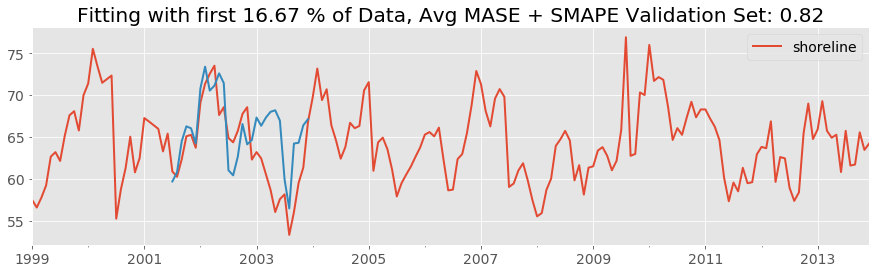

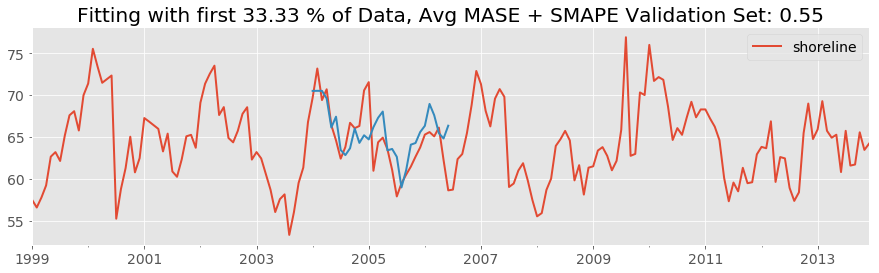

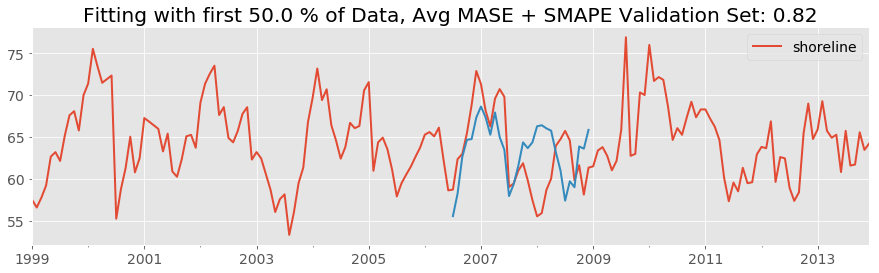

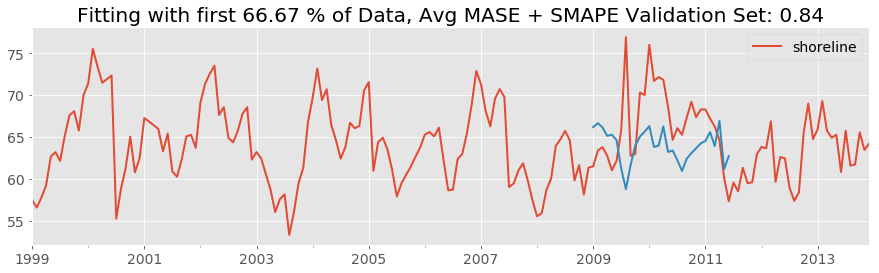

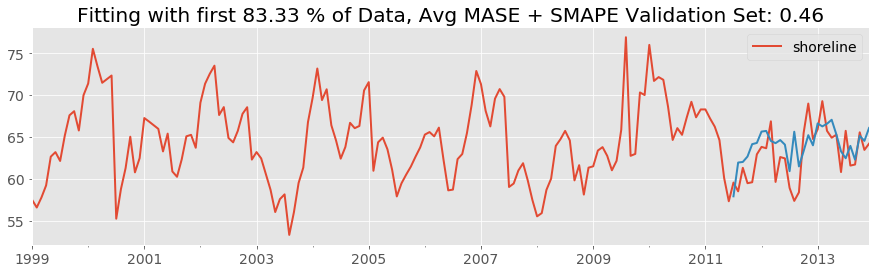

In [34]:
# Test Run ----------------------------------------------------------------------------------

splitter = sku.PurgedGroupTimeSeriesSplit(
    5, group_gap=0, max_train_group_size=365, max_test_group_size=100
)
groups = df_train_merged.index.date
cv_scores = []

for train_index, test_index in splitter.split(df_train_merged, groups=groups):

    cv_train = df_train_merged.iloc[train_index]
    cv_valid = df_train_merged.iloc[test_index]

    seasonal_forecast_model = sku.SARIMA_regressor(
        endog_col="shoreline",
        exog_cols=["wave_power"],
        order=(0, 0, 3),  # best_pdq[0],
        seasonal_order=(1, 1, 3, 12),  # best_seasonal_pdq,
        measurement_error=True,
    )
    seasonal_forecast_model.fit(cv_train)

    forecast = seasonal_forecast_model.predict(cv_valid)

    cv_mase_smape = avg_mase_smape(cv_valid["shoreline"], forecast)
    cv_scores.append(cv_mase_smape)

    fig, ax = plt.subplots()
    df_train_merged.plot(y="shoreline", ax=ax)
    forecast.plot(
        ax=ax,
        title=f"Fitting with first {round(100*len(cv_train)/len(df_train_merged),2)} % of Data, Avg MASE + SMAPE Validation Set: {round(cv_mase_smape,2)}",
    )

print(f"Avg MASE + SMAPE: {round(sum(cv_scores)/len(cv_scores),2)}")


So far - looks like SARIMAX can get ~ 0.7 on our Avg MASE + SMAPE metric with some tuning of what exogenous vars to include. Just using wave_power provided the best results on 5 fold validataion. Next lets use more machine learning feature engineering and boosting.

Quick visual of a CV strategy - I'll calculate our features individually on the train/validataion splits so I won't use a gap for now. If we wanted to speed up the CV process, we could pre calculate the transformations and then use a gap between train/validation splits to avoid leaking information.

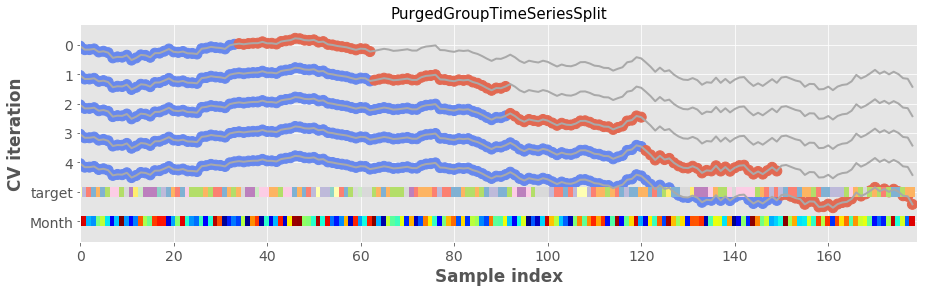

In [35]:
from sklearn.model_selection import TimeSeriesSplit

# Carefully shift target data one shift ahead. Need `id` to match data up to each timestamp to predict the change in the next timestamp
y_target = df_train_merged['shoreline'].shift(-1).dropna()
x_target = (
    df_train_merged[df_train_merged.index.isin(y_target.index)]
    .assign(id=1)
    .reset_index()
    .rename(columns={"index":"time"})
)

# Build CV object - Able to put a gap between train/validation and group by another column.
groups = np.linspace(1,x_target.shape[0],x_target.shape[0])
splitter = sku.PurgedGroupTimeSeriesSplit(
    5, group_gap=0, max_train_group_size=365
)

fig,ax = plt.subplots()
sku.plot_cv_indices(splitter, x_target['wave_power'].values, y_target.values, groups, ax=ax,n_splits=5, group_name="Month")



### ML Approach with Tsfresh + Boosting

Using `tsfresh` - lets calculate a large amount of features then prune. This should be all variations of transforms that we need to look at.

In [ ]:

# Setup to evaluate predicting different time shifts.
results = pd.DataFrame()

# Carefully shift target data one shift ahead. Need `id` to match data up to each timestamp to predict the change in the next timestamp
y_target = df_train_merged['shoreline'].shift(-1).dropna()
x_target = (
    df_train_merged[df_train_merged.index.isin(y_target.index)]
    .assign(id=1)
    .reset_index()
    .rename(columns={"index":"time"})
)

# Build CV object - Able to put a gap between train/validation and group by another column.
groups = x_target.time.dt.date
splitter = sku.PurgedGroupTimeSeriesSplit(
    5, group_gap=0, max_train_group_size=365, max_test_group_size=100
)

# This pipeline assumes the data frame already sorted by `time` column
search_pipeline = Pipeline(
    steps=[
        # ("ema", tfu.AddEma(days=[12], except_cols=["id", "time"])),
        (
            "windows",
            tfu.BuildRollingWindows(
                column_id="id",
                column_sort="time",
                max_timeshift=12,
                min_timeshift=0,
                n_jobs=0
            ),
        ),
        ("feat_gen", tfu.ExtractTSFeatures(column_id="id", column_sort="time", default_fc_parameters=ComprehensiveFCParameters(), n_jobs=0)),
        ("feat_prune", tfu.RemoveNACols()),
        ("remove_0_cols", tfu.RemoveZeroCols()),
        ("feat_select", tfu.SelectTSFeatures(n_jobs=0)),
        ("clf", LGBMRegressor(random_state=42)),
    ]
)

param_grid = {
    # "ema__days": [[3],[6],[12]],
    "windows__max_timeshift": [1],
    "clf__num_leaves" : [10], #default = 31
    "clf__min_child_samples":[10], # default=20
    "clf__n_estimators":[12,25] #default=100
}

grid = GridSearchCV(
    search_pipeline, param_grid=param_grid, cv=splitter, scoring=mase_smape_scorer, refit=True
)

grid.fit(x_target, y_target, groups=groups)

results = pd.concat([results, pd.DataFrame(grid.cv_results_)])


In [139]:
(
    results.sort_values("rank_test_score")
    [["params", 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score']]
       .style.background_gradient(
        subset="rank_test_score"
    )
    .set_caption("Results for TsFresh Engineered Features")
)



,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,"{'clf__min_child_samples': 10, 'clf__n_estimators': 25, 'clf__num_leaves': 10, 'windows__max_timeshift': 1}",-0.693981,-0.607316,-0.588064,-0.551916,-0.513464,-0.590948,0.060695,1
0,"{'clf__min_child_samples': 10, 'clf__n_estimators': 12, 'clf__num_leaves': 10, 'windows__max_timeshift': 1}",-0.736202,-0.570236,-0.608931,-0.597994,-0.528435,-0.608360,0.069704,2


In [38]:
pd.DataFrame(
    {
        "importance": grid.best_estimator_.named_steps[
            "clf"
        ].feature_importances_
    },
    index=grid.best_estimator_.named_steps[
        "feat_select"
    ].selected_features.values,
).sort_values("importance", ascending=False).style.background_gradient(
    subset="importance"
).set_caption(
    "LightGBM Feature Importance - HIGHER THE BETTER"
)


,importance
wave_power__quantile__q_0_4,74
wave_power__sum_values,57
shoreline__cwt_coefficients__coeff_0__w_10__widths__2_5_10_20_,41
shoreline__abs_energy,41
shoreline__sum_values,40
shoreline__median,35
wave_power__quantile__q_0_1,35
shoreline__quantile__q_0_2,33
wave_height__quantile__q_0_6,31
shoreline__quantile__q_0_4,28


### Ensembling Pipeline

Next - try ensembling SARIMA model with the tsFresh + LightGBM + Prophet....

In [ ]:
from sklearn.ensemble import VotingRegressor

# Setup to evaluate predicting different time shifts.
ensemble_results = pd.DataFrame()

# Carefully shift target data one shift ahead. Need `id` to match data up to each timestamp to predict the change in the next timestamp
y_target = df_train_merged["shoreline"].shift(-1).dropna()
x_target = (
    df_train_merged[df_train_merged.index.isin(y_target.index)]
    .assign(id=1)
    .reset_index()
    .rename(columns={"index": "time"})
)

# Build CV object - Able to put a gap between train/validation and group by another column.
groups = x_target.time.dt.date
splitter = sku.PurgedGroupTimeSeriesSplit(
    5, group_gap=0, max_train_group_size=365, max_test_group_size=100
)

# This pipeline assumes the data frame already sorted by `time` column
tsfresh_pipeline = Pipeline(
    steps=[
        # ("ema", tfu.AddEma(periods=[12], except_cols=["id", "time"])),
        (
            "windows",
            tfu.BuildRollingWindows(
                column_id="id",
                column_sort="time",
                max_timeshift=12,
                min_timeshift=0,
                n_jobs=0,
            ),
        ),
        (
            "feat_gen",
            tfu.ExtractTSFeatures(
                column_id="id",
                column_sort="time",
                default_fc_parameters=ComprehensiveFCParameters(),
                n_jobs=0,
            ),
        ),
        ("feat_prune", tfu.RemoveNACols()),
        ("remove_0_cols", tfu.RemoveZeroCols()),
        ("feat_select", tfu.SelectTSFeatures(n_jobs=0)),
        ("clf", LGBMRegressor(random_state=42)),
    ]
)

sarima_pipeline = Pipeline(
    steps=[
        (
            "sarima",
            sku.SARIMA_regressor(
                endog_col="shoreline",
                exog_cols=["wave_power"],
                order=(0, 0, 3),  # best_pdq[0],
                seasonal_order=(1, 1, 3, 12),  # best_seasonal_pdq,
                measurement_error=True,
            ),
        )
    ]
)

# prophet_pipeline = Pipeline(
#     steps=[
#         (
#             "prophet",
#             sku.Prophet_regressor(
#                 ds_col="time",
#                 target_col="shoreline",
#                 exog_cols=exog_vars,
#                 yearly_seasonalities=[10],
#                  yearly_periods=[365],
#                 changepoint_prior_scale=0.1,
#             ),
#         )
#     ]
# )

ensembled_pipe = VotingRegressor(
    estimators=[
        ("tsfresh", tsfresh_pipeline),
        ("sarima", sarima_pipeline),
        # ("prophet", prophet_pipeline),
    ]
)

param_grid = {
    # "tsfresh__ema__periods": [[3],[6],[12]],
    "tsfresh__windows__max_timeshift": [1],
    "tsfresh__clf__num_leaves" : [5,10],
    "tsfresh__clf__n_estimators" : [30,75],
    "tsfresh__clf__min_child_samples":[10]
    # "prophet__prophet__yearly_seasonality": [7, 8, 9, 10],
    
}

ensemble_grid = GridSearchCV(
    ensembled_pipe,
    param_grid=param_grid,
    cv=splitter,
    scoring=mase_smape_scorer,
    refit=True,
)

ensemble_grid.fit(x_target, y_target, groups=groups)

ensemble_results = pd.DataFrame(ensemble_grid.cv_results_)


In [44]:
(
    ensemble_results.sort_values("rank_test_score")
    [["params", 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score']]
       .style.background_gradient(
        subset="rank_test_score"
    )
    .set_caption("Results for Ensemble SARIMA + TsFresh Engineered Features")
)

,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'tsfresh__clf__min_child_samples': 10, 'tsfresh__clf__num_estimators': 30, 'tsfresh__clf__num_leaves': 5, 'tsfresh__windows__max_timeshift': 1}",-0.734472,-0.583660,-0.684933,-0.585342,-0.484276,-0.614537,0.087308,1
2,"{'tsfresh__clf__min_child_samples': 10, 'tsfresh__clf__num_estimators': 90, 'tsfresh__clf__num_leaves': 5, 'tsfresh__windows__max_timeshift': 1}",-0.734472,-0.583660,-0.684933,-0.585342,-0.484276,-0.614537,0.087308,1
1,"{'tsfresh__clf__min_child_samples': 10, 'tsfresh__clf__num_estimators': 30, 'tsfresh__clf__num_leaves': 10, 'tsfresh__windows__max_timeshift': 1}",-0.734472,-0.594923,-0.675372,-0.597684,-0.509574,-0.622405,0.076762,3
3,"{'tsfresh__clf__min_child_samples': 10, 'tsfresh__clf__num_estimators': 90, 'tsfresh__clf__num_leaves': 10, 'tsfresh__windows__max_timeshift': 1}",-0.734472,-0.594923,-0.675372,-0.597684,-0.509574,-0.622405,0.076762,3


In [45]:
pd.DataFrame(
    {
        "importance": ensemble_grid.best_estimator_.named_estimators_["tsfresh"].named_steps["clf"].feature_importances_
    },
    index=ensemble_grid.best_estimator_.named_estimators_["tsfresh"].named_steps["feat_select"].selected_features.values,
).sort_values("importance", ascending=False).style.background_gradient(
    subset="importance"
).set_caption(
    "LightGBM Feature Importance - HIGHER THE BETTER"
)

,importance
wave_power__quantile__q_0_4,43
shoreline__quantile__q_0_4,21
wave_power__quantile__q_0_1,18
wave_height__quantile__q_0_8,17
shoreline__abs_energy,17
shoreline__median,16
shoreline__cwt_coefficients__coeff_0__w_10__widths__2_5_10_20_,15
shoreline__quantile__q_0_2,15
wave_power__median,15
wave_power__quantile__q_0_2,14


#### Attempt At Tuning Prophet Hyper Params:

In [ ]:
splitter = sku.PurgedGroupTimeSeriesSplit(
    5, group_gap=0, max_train_group_size=365, max_test_group_size=100
)

prophet_pipeline = Pipeline(
    steps=[
        (
            "prophet",
            sku.Prophet_regressor(
                ds_col="index",
                target_col="shoreline",
                exog_cols=exog_vars,
                yearly_seasonalities=[10],
                yearly_periods=[365],
                changepoint_prior_scale=30,
                n_changepoints=3
            ),
        )
    ]
)

param_grid = {
    "prophet__yearly_seasonalities": [[5]],
    "prophet__yearly_periods": [[365]],
}

prophet_grid = GridSearchCV(
    prophet_pipeline,
    param_grid=param_grid,
    cv=splitter,
    scoring=mase_smape_scorer,
)

prophet_grid.fit(
    df_train_merged.reset_index(),
    df_train_merged["shoreline"],
    groups=df_train_merged.index.date,
)

pd.DataFrame(prophet_grid.cv_results_)


Not great results with Prophet - tried tweaking the majority of settings but it appeared to have difficulty learning the initial data/smaller data sets. It could achieve ~ 0.68 scores on it's own on the last fold of the CV process. 

## Recursive Forecasting Over Test Data Set

In [46]:
df_waves_test = pd.read_csv("data/waves-test.csv", index_col="time", parse_dates=True)

df_test_merged = (df_test
.merge(df_waves_test, left_index=True, right_index=True)
.merge(df_soi, left_index=True, right_index=True)
.merge(df_sea_data, left_index=True, right_index=True))




## TSFRESH RECURSIVE:

In [143]:
# Iterate, recursively adding a new shoreline value to the data frame.
# Pass back through tsfresh pipeline + regressor to generate features and make prediction of next step
# Takes ~ 35 minutes to run

X_forecasting = df_train_merged.copy()
X_forecasting = (
    X_forecasting.reset_index().rename(columns={"index": "time"}).assign(id=1)
)

exog_vars = ["wave_power", "wave_height", "soi", "adt", "vgos", "ugos"]
tsfresh_window_size = grid.best_estimator_.named_steps["windows"].max_timeshift

for steps in range(1, len(df_test_merged.index) + 1):

    # Only use the necessary data from train set to calculate 
    next_step_pred = grid.best_estimator_.predict(X_forecasting.iloc[-2*tsfresh_window_size:])[-1:]

    # Join exog vars back on for predicting next step
    next_step_df = (
        pd.DataFrame(
            {"shoreline": next_step_pred},
            index=[X_forecasting["time"].iloc[-1] + pd.offsets.MonthBegin(1)],
        )
        .reset_index()
        .rename(columns={"index": "time"})
        .assign(id=1)
        .merge(df_test_merged[exog_vars], left_on="time", right_index=True)
    )

    # Add to end and repeat
    X_forecasting = pd.concat([X_forecasting, next_step_df])

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


In [144]:
forecast_tsfresh = (
    X_forecasting[X_forecasting.time.isin(df_test_merged.index)][
        ["time", "shoreline"]
    ]
    .rename(columns={"time": "Time", "shoreline": "Shoreline"})
    .assign(Time = lambda x:x["Time"].dt.strftime('%b-%y'))
)

forecast_tsfresh.to_csv("data/beach-test-tsfresh.csv", index=False)


## SARIMA

In [145]:
seasonal_forecast_model = sku.SARIMA_regressor(
    endog_col="shoreline",
    exog_cols=["wave_power"],
    order=(0, 0, 3),  # best_pdq[0],
    seasonal_order=(1, 1, 3, 12),  # best_seasonal_pdq,
    measurement_error=True,
)
seasonal_forecast_model.fit(df_train_merged)

forecast_sarima_raw = seasonal_forecast_model.predict(df_test_merged)


C:\Users\Drumm\miniconda3\envs\mds574\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [146]:

forecast_sarima = (forecast_sarima_raw
.reset_index()
.rename(columns={"index":"Time", "predicted_mean":"Shoreline"})
.assign(Time = lambda x:x["Time"].dt.strftime('%b-%y'))
)

forecast_sarima.to_csv("data/beach-test-sarima.csv",index=False)

## PROPHET

In [147]:
prophet_model = sku.Prophet_regressor(
                ds_col="index",
                target_col="shoreline",
                exog_cols=exog_vars,
                yearly_seasonalities=[10],
                yearly_periods=[365],
                changepoint_prior_scale=30,
                n_changepoints=3
            )

prophet_model.fit(
    df_train_merged.reset_index(),
    df_train_merged["shoreline"],
)

prophet_forecast = prophet_model.predict(    
    df_test_merged.reset_index(),
)


In [148]:
forecast_prophet = (forecast_sarima.assign(Shoreline = prophet_forecast))
forecast_prophet.to_csv("data/beach-test-prophet.csv", index=False)

## Combine and Compare

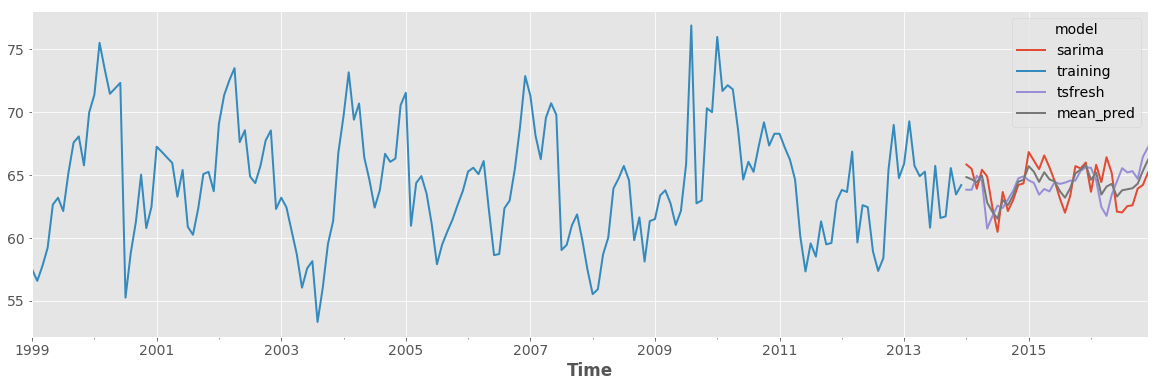

In [167]:
df_summary = pd.concat(
    [
        df_train_merged.assign(Time=lambda x: x.index.strftime("%b-%y"))
        .rename(columns={"shoreline": "Shoreline"})
        .assign(model="training"),
        forecast_sarima.assign(model="sarima"),
        forecast_tsfresh.assign(model="tsfresh"),
        # forecast_prophet.assign(model="prophet")
    ]
).assign(Time=lambda x: pd.to_datetime(x.Time, format="%b-%y"))

df_summary.index = df_summary.Time

df_mean_pred = (
    df_summary.pivot(columns="model", values="Shoreline")
    .assign(mean_pred=lambda x: x[["sarima", "tsfresh"]].mean(axis=1))
    .reset_index()[["Time", "mean_pred"]]
    .rename(columns={"mean_pred": "Shoreline"})
    .assign(Time=lambda x: x["Time"].dt.strftime("%b-%y"))
    .tail(len(df_test))[["Time", "Shoreline"]]
)

df_mean_pred.to_csv("data/beach-test.csv", index=False)

(
    df_summary.pivot(columns="model", values="Shoreline")
    .assign(mean_pred=lambda x: x[["sarima", "tsfresh"]].mean(axis=1))
    .plot.line(figsize=(20,6))
)



I've decide to submit the averaged predictions of my SARIMAX model and the TsFresh + LightGBM tuned model. This can be seen as `mean_pred` above.

## Submit to Canvas and GitHub
<hr>

**Be sure to push your predictions .csv file to GitHub so I can evaluate it**. You should also submit a HTML-render of your assignment to Canvas as-per-usual so we can look at your code and plot (you do not need to submit your .csv predictions to Canvas).

When you are ready to submit your assignment do the following:
1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Run All Cells...`
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below or by `File -> Export Notebook As... -> Export Notebook to HTML`
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
5. Finally, push all your work to GitHub (including the rendered html file).

In [168]:
convert_notebook("lab3.ipynb", "html")  # save your notebook, then uncomment and run when you want to convert to html

Notebook successfully converted! 


In [173]:
# submit(course_code=59092)  # uncomment and run when ready to submit to Canvas